In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import numpy as np
import os
import torch.nn.functional as F

# MultiShapeDataset
1. คลาส MultiShapeDataset ถูกสร้างเพื่อ สุ่ม รูปร่าง (วงกลมหรือสี่เหลี่ยม) บนภาพ ขนาด 64×64 (หรือขนาดที่กำหนดเอง) โดยให้มี จำนวนวัตถุสูงสุด ตามค่า max_objects
2. ในการสุ่ม สคริปต์จะ ป้องกันการซ้อนทับกันเกิน 70% เพื่อให้วัตถุมีความหลากหลายและมี label ที่ชัดเจน
3. เมื่อต้องการใช้งานจริงกับ PyTorch ก็เพียงสร้าง dataset และส่งเข้า DataLoader เช่น
```python
dataset = MultiShapeDataset(num_samples=1000, image_size=(64, 64), max_objects=2)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)
```
4. แต่ละครั้งที่เข้าถึง (ด้วย for imgs, labels in dataloader:) เราจะได้เทนเซอร์ imgs (B, 1, 64, 64) และเทนเซอร์ labels (B, max_objects, 5)
 * labels[:, :, 0] คือ index ของ shape (0 = circle, 1 = rectangle, -1 คือไม่มีวัตถุ)
 * labels[:, :, 1:3] คือ (center_x, center_y) แบบ normalized
 * labels[:, :, 3:5] คือ (width, height) แบบ normalized

In [2]:
class MultiShapeDataset(Dataset):
    def __init__(self, num_samples=1000, image_size=(64, 64), max_objects=2):
        self.num_samples = num_samples
        self.image_size = image_size
        self.min_size = min(image_size)
        self.max_objects = max_objects
        self.shapes = ['circle', 'rectangle']
        self.data = []
        self.generate_data()

    def generate_data(self):
        n_im = 0
        while n_im < self.num_samples:
            img = np.zeros((self.image_size[1], self.image_size[0]), dtype=np.float32)
            labels = []
            shapes_list = []
            num_objects = np.random.randint(1, self.max_objects + 1)  # จำนวนวัตถุที่สุ่มได้

            # 1) สุ่มสร้างวัตถุ (num_objects ชิ้น)
            for _ in range(num_objects):
                shape = np.random.choice(self.shapes)  # เลือกว่าเป็น circle หรือ rectangle

                if shape == 'circle':
                    # -----------------------------
                    # กรณีเป็นวงกลม (circle)
                    # -----------------------------

                    min_r = self.min_size // 10
                    r = np.random.randint(min_r, (self.min_size - min_r) // 2)  # สุ่มรัศมี
                    x = np.random.randint(r, self.image_size[0] - r)           # จุดศูนย์กลาง x
                    y = np.random.randint(r, self.image_size[1] - r)           # จุดศูนย์กลาง y

                    # สร้าง grid ในแกน (y, x)
                    rr, cc = np.ogrid[:self.image_size[1], :self.image_size[0]]
                    dist = np.sqrt((rr - y) ** 2 + (cc - x) ** 2)  # คำนวณระยะจากจุด (x, y)
                    shape_mask = (dist <= r)                      # ส่วนที่อยู่ในรัศมีจะเป็น True

                    # w, h เป็นเส้นผ่านศูนย์กลาง (2*r)
                    w, h = 2 * r, 2 * r

                    # คำนวณพื้นที่ (จำนวน pixel) ของ mask
                    area = np.sum(shape_mask)

                else:
                    # -----------------------------
                    # กรณีเป็นสี่เหลี่ยม (rectangle)
                    # -----------------------------

                    min_w = self.image_size[1] // 10  # ความกว้างขั้นต่ำ
                    min_h = self.image_size[0] // 10  # ความสูงขั้นต่ำ
                    w = np.random.randint(min_w, (self.image_size[1] - min_w) // 2)  # สุ่มความกว้าง
                    h = np.random.randint(min_h, (self.image_size[0] - min_h) // 2)  # สุ่มความสูง

                    # สุ่มตำแหน่งกึ่งกลาง (x, y)
                    x = np.random.randint(w // 2, self.image_size[0] - w // 2)
                    y = np.random.randint(h // 2, self.image_size[1] - h // 2)

                    # สร้าง mask ว่า pixel ไหนบ้างเป็นรูปสี่เหลี่ยม
                    shape_mask = np.zeros_like(img, dtype=bool)
                    shape_mask[
                        max(0, y - h // 2) : min(self.image_size[1], y + h // 2),
                        max(0, x - w // 2) : min(self.image_size[0], x + w // 2)
                    ] = True

                    # พื้นที่ (จำนวน pixel) ของ mask
                    area = np.sum(shape_mask)

                # เก็บรายละเอียดของ shape แต่ละอันในรูปแบบ tuple
                # (area, shape_mask, shape, x, y, w, h)
                shapes_list.append((area, shape_mask, shape, x, y, w, h))

            # 2) จัดเรียงวัตถุจากใหญ่ -> เล็ก (descending order) ตามค่า area
            shapes_list.sort(reverse=True, key=lambda x: x[0])

            # 3) ไล่เพิ่มวัตถุแต่ละตัวลงในรูปภาพ (img)
            for area, shape_mask, shape, x, y, w, h in shapes_list:
                # overlap = บริเวณที่ shape นี้ทับกับวัตถุที่มีอยู่แล้วบนภาพ (1 คือวัตถุ)
                overlap = np.logical_and(shape_mask, img)
                overlap_area = np.sum(overlap)      # ขนาดพื้นที่ที่ซ้อนกัน
                shape_area = np.sum(shape_mask)     # ขนาดพื้นที่ทั้งหมดของ shape

                # ถ้าพื้นที่วัตถุซ้อนเกินกว่า 70% จะไม่วาดวัตถุนี้ลงไป
                if shape_area > 0 and (overlap_area / shape_area) < 0.7:
                    # ถ้าซ้อนไม่เกิน 70% ก็ใส่ (1) ลงใน img ตาม mask
                    img[shape_mask] = 1
                    # สร้าง label: [ind_shape, center_x, center_y, width_norm, height_norm]
                    labels.append([
                        self.shapes.index(shape),  # 0 สำหรับ circle, 1 สำหรับ rectangle
                        x / self.image_size[0],    # Normalize ตำแหน่ง x
                        y / self.image_size[1],    # Normalize ตำแหน่ง y
                        w / self.image_size[0],    # Normalize ความกว้าง
                        h / self.image_size[1],    # Normalize ความสูง
                    ])

            # 4) ถ้าจำนวน label ยังไม่ถึง max_objects ให้เติม placeholder เข้าไป
            while len(labels) < self.max_objects:
                # ใส่ [-1, 0, 0, 0, 0] เป็นการบอกว่าไม่มีวัตถุ
                labels.append([-1, 0, 0, 0, 0])

            # 5) ถ้าภาพมีวัตถุจริง (pixel ที่เป็น 1 มีจำนวนมากกว่า 0)
            if np.sum(img) > 0:
                # เก็บ (img, labels) ไว้ใน self.data
                self.data.append((img, labels))
                n_im += 1  # สร้างภาพเสร็จไปแล้ว 1 ภาพ

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        img, labels = self.data[idx]
        # img เป็น numpy array ขนาด (Height, Width) ต้องเปลี่ยนเป็น torch.tensor และ unsqueeze(0) เพื่อให้ shape กลายเป็น (1, H, W) (ทำเป็น channel 1)
        # labels ก็เปลี่ยนเป็น torch.tensor โดยจะมี shape ประมาณ (max_objects, 5) ตามที่เราเก็บไว้
        return torch.tensor(img).unsqueeze(0), torch.tensor(labels)


## สรุปการทำงาน generate_data
1. เริ่มจาก n_im = 0 แล้วทำซ้ำจนกว่าจะครบ num_samples
2. สร้างภาพว่าง (img) ขนาดตาม image_size (ค่าเริ่มต้น 64×64) โดยในตอนแรกค่าเป็นศูนย์ทั้งหมด
3. สุ่มจำนวนวัตถุ ตั้งแต่ 1 ชิ้นจนถึง max_objects
4. สำหรับวัตถุแต่ละชิ้น สุ่มว่าจะเป็นวงกลมหรือสี่เหลี่ยม
 * วงกลม (circle): สุ่มรัศมี r และตำแหน่ง (x, y) โดยคำนึงไม่ให้เกินขอบเขตภาพ
 * สี่เหลี่ยม (rectangle): สุ่มความกว้าง w ความสูง h และตำแหน่งกึ่งกลาง (x, y)
 * สร้าง mask (boolean array) เพื่อระบุพิกเซลใดเป็นรูปร่างนั้น ๆ
 * คำนวณ area = จำนวนพิกเซลที่เป็นวัตถุ
 * เก็บเป็น tuple (area, shape_mask, shape, x, y, w, h) เข้า shapes_list
5. เรียงลำดับ shapes_list จากรูปร่างที่มีพื้นที่มากที่สุดไปหาน้อยที่สุด (descending)
6. ตรวจสอบการซ้อนทับ (overlap) กับวัตถุที่มีอยู่บนภาพ
 * ถ้าซ้อนทับไม่เกิน 70% ของรูปใหม่ ก็เอารูปนั้นมาวางทับใน img (โดยเซ็ตเป็น 1) แล้วบันทึกค่าลงใน labels
7. เติม labels ให้ครบ max_objects หากใส่น้อยกว่า ก็ใส่ placeholder [-1, 0, 0, 0, 0]
8. ตรวจว่าในภาพมีวัตถุอย่างน้อย 1 ชิ้น (เช็ค np.sum(img) > 0) ถ้ามีก็เก็บ (img, labels) เข้า self.data และเพิ่มตัวนับ n_im
9. ทำซ้ำจนกว่าจะได้ num_samples ภาพที่มีวัตถุเรียบร้อย

In [3]:
num_samples=1000
data=MultiShapeDataset(num_samples=num_samples, max_objects=5)

196
tensor([[ 0.0000,  0.4531,  0.7031,  0.4062,  0.4062],
        [ 1.0000,  0.2500,  0.2031,  0.2812,  0.3438],
        [ 1.0000,  0.7500,  0.3125,  0.1719,  0.4219],
        [-1.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [-1.0000,  0.0000,  0.0000,  0.0000,  0.0000]])


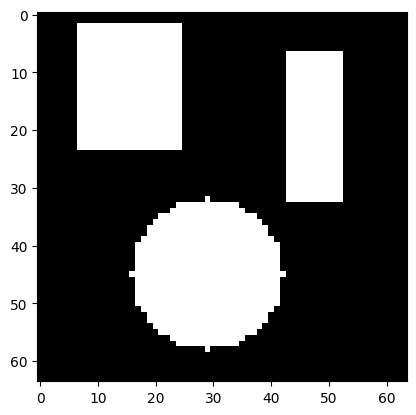

In [4]:
i=np.random.randint(0,num_samples)
print(i)
plt.imshow(data.__getitem__(i)[0][0],cmap='gray')
print(data.__getitem__(i)[1])

# โมดูล Attention สไตล์ CBAM ร่วมกับโครงสร้าง ResNet

## Convolutional Block Attention Module (CBAM)

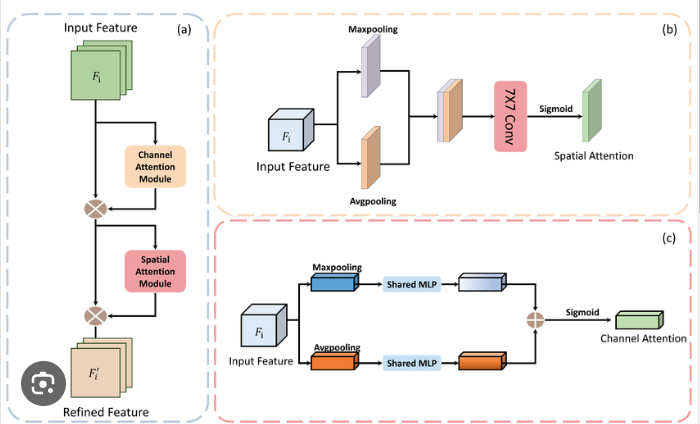

### 1) Channel Attention Module

In [5]:
# Define the Channel Attention Module
class ChannelAttention(nn.Module):
    def __init__(self, in_channels, reduction_ratio=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1) # Calculate each channels avg and max value in order to let network focus on overall info of different channel
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        self.fc = nn.Sequential(
            nn.Conv2d(in_channels, in_channels // reduction_ratio, kernel_size=1), # C//r=1000/16=62
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels // reduction_ratio, in_channels, kernel_size=1)
        )
        # self.fc = nn.Sequential(
        #     nn.Linear(in_channels, in_channels // reduction_ratio),
        #     nn.ReLU(inplace=True),
        #     nn.Linear(in_channels // reduction_ratio, in_channels)
        # )
        self.sigmoid = nn.Sigmoid()

    def forward(self, x): # x=[B, C, H, W]
        avg_out = self.fc(self.avg_pool(x)) # [B, C, 1, 1]
        max_out = self.fc(self.max_pool(x)) # [B, C, 1, 1]
        out = avg_out + max_out
        return self.sigmoid(out)
        #return self.sigmoid(out) * x

1. รับพารามิเตอร์ in_channels (จำนวน channel ของ feature map) และ reduction_ratio (ค่าลดจำนวน channel เพื่อให้โมเดลเล็กลง)
2. self.avg_pool = nn.AdaptiveAvgPool2d(1)
 * ทำ Average Pooling ตามตำแหน่ง spatial (H×W) ลงมาเหลือขนาด 1×1
 * ผลลัพธ์ได้เทนเซอร์ขนาด [B, C, 1, 1] (B=Batch, C=Channels)
3. self.max_pool = nn.AdaptiveMaxPool2d(1)
 * ทำ Max Pooling ตามตำแหน่ง spatial (H×W) ลงมาเหลือขนาด 1×1
 * ผลลัพธ์ก็ได้ [B, C, 1, 1] อีกเช่นกัน
4. self.fc เป็น Sequential ประกอบด้วย
 * nn.Conv2d(in_channels, in_channels // reduction_ratio, kernel_size=1)
ลดจำนวน channel จาก C ไปเป็น C//r (เช่น 64 → 4 ถ้า r=16)
 * nn.ReLU(inplace=True)
 * nn.Conv2d(in_channels // reduction_ratio, in_channels, kernel_size=1)
5. เพิ่ม channel กลับมาเป็นขนาด C เช่นเดิม
self.sigmoid = nn.Sigmoid() เพื่อ scale ค่าให้อยู่ในช่วง [0, 1]
6. ขั้นตอนใน forward
 * avg_out = self.fc(self.avg_pool(x)):
นำค่าที่ผ่าน adaptive avg pooling (1×1) ไปเข้า Fully Connected (แต่ใช้ Conv1×1 แทน)
 * max_out = self.fc(self.max_pool(x)):
ทำแบบเดียวกันกับส่วน Max Pooling
 * out = avg_out + max_out:
รวม (element-wise) เพื่อให้ได้ค่าความสำคัญ (attention) ของแต่ละ channel
 * return self.sigmoid(out):
ทำ sigmoid ให้ค่าระหว่าง 0 ถึง 1 สุดท้ายได้ attention map ขนาด [B, C, 1, 1]


### 2) Spatial Attention Module

In [6]:
# Define the Spatial Attention Module
class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        self.conv = nn.Conv2d(2, 1, kernel_size=kernel_size, padding=kernel_size//2)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True) # DIM is in the first dimension, which is after the batch size, so it is defined as [B,1,H,W].
        max_out, _ = torch.max(x, dim=1, keepdim=True) # [B, 1, H, W]
        x = torch.cat([avg_out, max_out], dim=1) # [B, 2, H, W]
        x = self.conv(x) # [B, 1, H, W]
        return self.sigmoid(x) # [B, 1, H, W] (final attention map)
        #return self.sigmoid(out) * x

1. รับพารามิเตอร์ kernel_size (ค่าเริ่มต้น=7) สำหรับ Convolution
2. self.conv = nn.Conv2d(2, 1, kernel_size=7, padding=3)
 * รับ 2 ช่อง (เนื่องจากเราจะ cat avg_out กับ max_out)
 * ได้ 1 ช่องเป็นผลลัพธ์ (attention map)
3. self.sigmoid = nn.Sigmoid() เพื่อให้ค่าระหว่าง 0 ถึง 1
4. ขั้นตอนใน forward
 * avg_out = torch.mean(x, dim=1, keepdim=True)
หา average ตามแกน channel => ได้ [B, 1, H, W]
 * max_out, _ = torch.max(x, dim=1, keepdim=True)
หา max ตามแกน channel => ได้ [B, 1, H, W]
 * x = torch.cat([avg_out, max_out], dim=1)
ต่อเทนเซอร์ในแกน channel => ได้ [B, 2, H, W]
 * x = self.conv(x)
Convolution 7×7 เพื่อเรียนรู้โครงสร้าง spatial
 * return self.sigmoid(x)
คืนค่าเป็นขนาด [B, 1, H, W] (spatial attention map)

### 3) CBAMAttention Module (Channel + Spatial)

In [7]:
# Define the CBAM-like Attention Module
class CBAMAttention(nn.Module):
    def __init__(self, in_channels):
        super(CBAMAttention, self).__init__()
        self.channel_att = ChannelAttention(in_channels)
        self.spatial_att = SpatialAttention()

    def forward(self, x):
        x = x * self.channel_att(x) # x* [B, C, 1, 1] = [B, C, H, W]
        x = x * self.spatial_att(x) # x * [B, 1, H, W] = [B, C, H, W]

        return x

1. ใช้โครงสร้าง Conv-BN-ReLU-Conv-BN ภายในบล็อกเดียวกัน
2. มี skip connection (out += identity) เพื่อส่งผ่านข้อมูลขาเข้าตรงไปที่ขาออก
3. ถ้า in_channels != out_channels จะต้องทำ downsample ด้วย Conv 1×1 และ BN เพื่อปรับขนาด channel ให้เท่ากัน

## ResidualBlock (Block ของ ResNet)
https://github.com/samcw/ResNet18-Pytorch/blob/master/ResNet18.ipynb

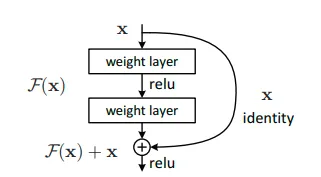

In [8]:
# Define a residual block with skip connection
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, bias=False),
            nn.BatchNorm2d(out_channels)
        ) if in_channels != out_channels else None

    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample is not None:
            identity = self.downsample(x)
        out += identity  # Skip connection
        out = self.relu(out)
        return out

# โครงสร้างเครือข่ายหลัก

## ResNet18 and ResNet18 with Attention

## ResNet with Attention nano

In [9]:
class ResNetwithAttention_nano(nn.Module):
    def __init__(self, im_channels=3, num_classes=10):
        super().__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(im_channels, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)

        # สร้างเลเยอร์ (ResidualBlock) 2 ชุด
        self.layer1 = self._make_layer(64, 1)   # 1 block out_channels=64
        self.layer2 = self._make_layer(128, 2) # 2 blocks out_channels=128

        # CBAM Attention (กับจำนวน channel = 128)
        self.cbam = CBAMAttention(128)

        # Adaptive Average Pool -> 1x1
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(128, num_classes)

    def _make_layer(self, out_channels, num_blocks):
        layers = []
        for _ in range(num_blocks):
            layers.append(ResidualBlock(self.in_channels, out_channels))
            self.in_channels = out_channels
        return nn.Sequential(*layers)

    def forward(self, x):
        # 1) Conv + BN + ReLU เริ่มต้น
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        # 2) ผ่าน layer1 (1 Block) ขนาดยังเป็น 64 channels
        out = self.layer1(out)

        # 3) ผ่าน layer2 (2 Blocks) ขยายเป็น 128 channels
        out = self.layer2(out)

        # 4) ใส่ CBAM Attention
        out = self.cbam(out)

        # 5) Average Pool -> 1x1
        out = self.avg_pool(out)    # [B, 128, 1, 1]

        # 6) Flatten และผ่าน Fully Connected
        out = torch.flatten(out, 1) # [B, 128]
        out = self.fc(out)          # [B, num_classes]

        return out

**สรุปโครงสร้าง**

1. Conv1 + BN + ReLU รับภาพขนาด im_channels → ออกมาเป็น 64 channels
2. layer1 (มี 1 ResidualBlock) ใช้ out_channels=64 → ยังคง 64
3. layer2 (มี 2 ResidualBlock) สุดท้ายจะเป็น 128 channels
4. CBAMAttention(128) รับ feature ขนาด 128 channels มาทำ channel + spatial attention
5. AdaptiveAvgPool2d(1,1) ลด spatial เหลือ 1×1
6. Fully Connected (linear) output เป็น num_classes (เช่น 10)

การ forward(x) จึงมีลำดับตาม step ข้างต้น ส่งผลให้ได้ feature map ที่ถูกปรับแต่งด้วย attention ก่อนจะนำไปทำการ classify ในตอนท้าย

In [10]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_workers = os.cpu_count()
print(f"Using device: {device}")
print(f"Number of workers: {num_workers}")

Using device: cpu
Number of workers: 2


In [12]:
dataset = MultiShapeDataset(num_samples=500, max_objects=5)
train_loader = DataLoader(dataset, batch_size=32, shuffle=True,num_workers=num_workers)

# Classification problem (ทำนายชนิดของวัตถุที่มีขนาดใหญ่ที่สุดในรูป)
ResNetwithAttention_nano (สำหรับภาพขาว-ดำ 1 channel และจำนวนคลาส 1) และฟังก์ชัน train_bigest_shape_model ซึ่งทำการเทรนโมเดลด้วย DataLoader, Loss, และ Optimizer ที่กำหนด
* ResNetwithAttention_nano(im_channels=1, num_classes=1)
เรียกใช้คลาส ResNetwithAttention_nano ซึ่งภายในกำหนดว่า
 * im_channels=1 หมายถึง Input มี 1 channel (เช่น ภาพ Grayscale หรือ single-channel)
 * num_classes=1 หมายถึง Output สุดท้ายของ FC Layer เป็น 1 neuron เท่านั้น
(มักใช้ในงาน Classification แบบ Binary หรือ Output เป็นค่าตัวเดียว)

In [13]:
# Create and train the model
model = ResNetwithAttention_nano(im_channels=1,num_classes=1)
print(f"Total trainable parameters: {count_parameters(model)}")

def train_bigest_shape_model(model, train_loader,criterion,optimizer, num_epochs=20):
    model = model.to(device)
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            outputs = torch.sigmoid(outputs)
            loss = criterion(outputs, labels[:,0][:,0].unsqueeze(1))
            loss.backward()
            optimizer.step()
            running_loss += loss.cpu().item()
        print(f'Epoch {epoch+1}, Loss: {running_loss/len(train_loader):.4f}')

Total trainable parameters: 602732


In [14]:
# criterion = nn.BCELoss()
# optimizer = optim.Adam(model.parameters(), lr=0.001)
# train_bigest_shape_model(model, train_loader,criterion,optimizer, num_epochs=10)

## วัดประสิทธิภาพและทดสอบใช้งาน

In [15]:
# Function to perform inference and collect predictions
def perform_inference(model, test_loader):
    model.eval()  # Set the model to evaluation mode
    predictions = []
    true_labels = []
    with torch.no_grad():  # Disable gradient calculation for inference
        for images, labels in test_loader:
            images = images.to(device)
            outputs = model(images)
            outputs = torch.sigmoid(outputs)
            predicted_labels = (outputs > 0.5).int()  # Convert probabilities to binary predictions
            predictions.extend(predicted_labels.cpu().numpy())
            true_labels.extend(labels[:,0][:,0].unsqueeze(1).cpu().numpy())
    return np.array(predictions), np.array(true_labels)

Test Accuracy: 0.82


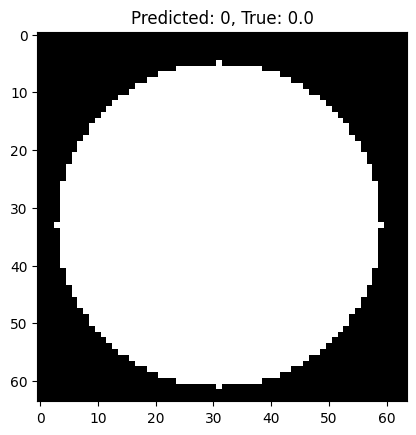

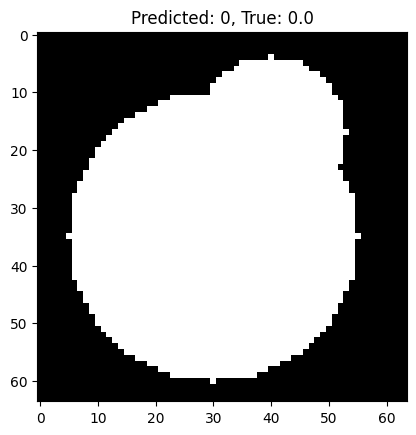

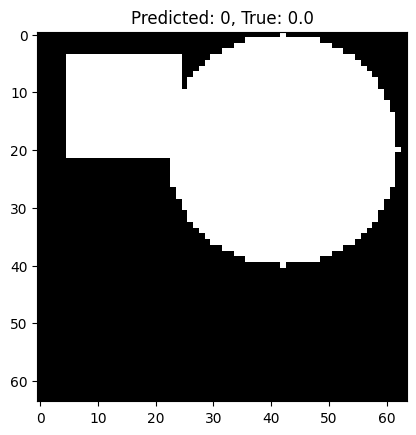

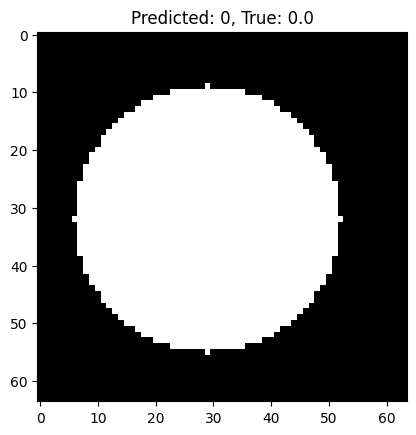

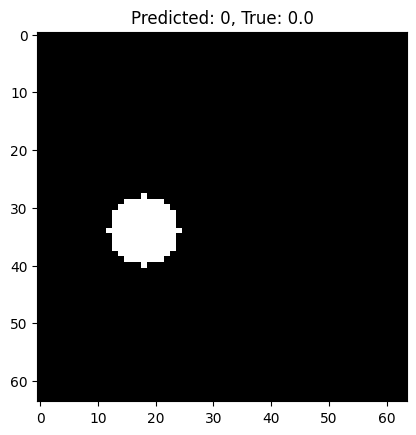

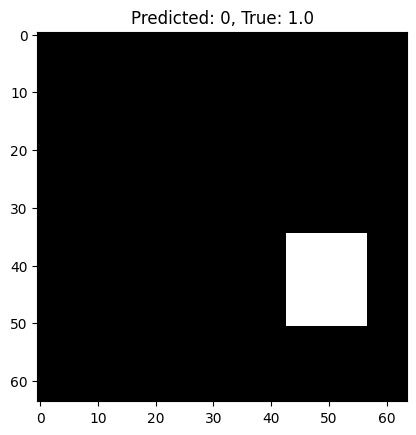

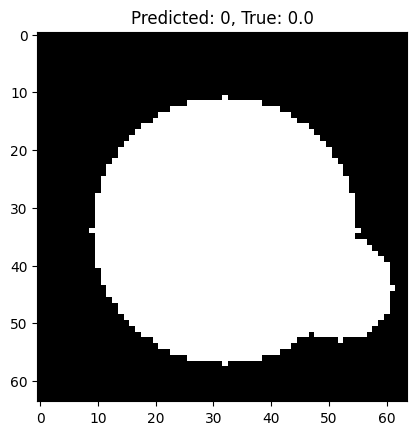

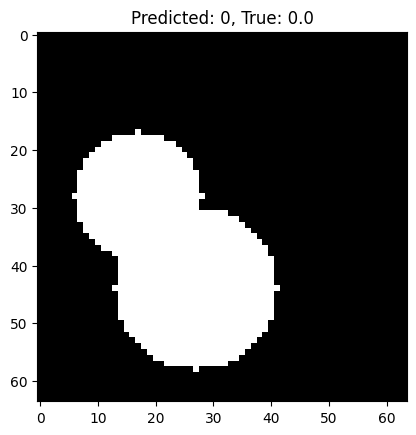

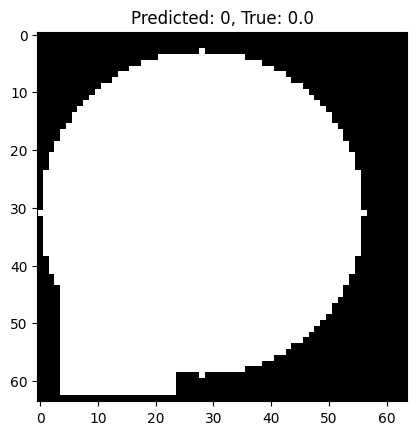

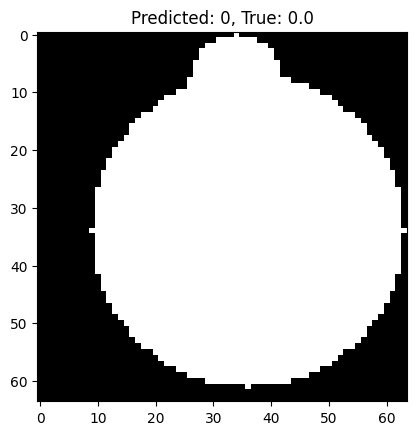

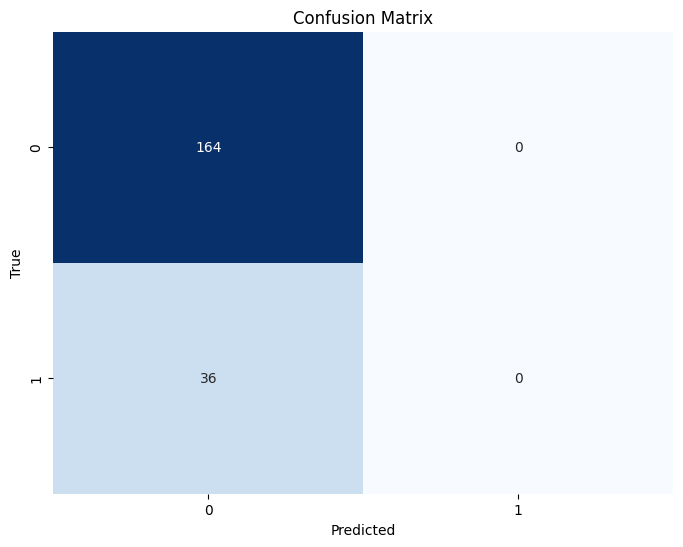

In [16]:
# prompt: create inference and visualize model performance on new test set

import numpy as np
# Assuming the model and training process are complete as in the previous code.

# Create a new test dataset
test_dataset = MultiShapeDataset(num_samples=200, max_objects=5)  # Adjust num_samples as needed
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=num_workers)

# Perform inference on the test set
predictions, true_labels = perform_inference(model, test_loader)

# Calculate accuracy
accuracy = np.mean(predictions == true_labels)
print(f"Test Accuracy: {accuracy}")


# Visualize some predictions (optional)
import matplotlib.pyplot as plt

# Example: Show the first 10 images with their predicted and true labels
num_images_to_show = 10
for i in range(min(num_images_to_show, len(test_dataset))):
    image, label = test_dataset[i]
    predicted_label = predictions[i]
    plt.imshow(image.squeeze(), cmap='gray')  # Assuming grayscale images
    plt.title(f"Predicted: {predicted_label[0]}, True: {label[0][0]}")
    plt.show()


# Plot confusion matrix (optional)
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


# Self-supervised learning: NPairLoss

In [17]:
# -------------------------
# Self-Supervised Dataset
# -------------------------
# Define an augmentation pipeline (feel free to adjust for grayscale images)
augmentation = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomResizedCrop(size=64, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=15),
    transforms.ToTensor(),
])

class SelfSupervisedMultiShapeDataset(MultiShapeDataset):
    def __init__(self, num_samples=1000, image_size=(64, 64), max_objects=2, transform=None):
        super().__init__(num_samples=num_samples, image_size=image_size, max_objects=max_objects)
        self.transform = transform

    def __getitem__(self, idx):
        img, labels = self.data[idx]
        # Apply the augmentation twice to generate two views
        if self.transform is not None:
            view1 = self.transform(img)
            view2 = self.transform(img)
        else:
            view1 = torch.tensor(img)
            view2 = torch.tensor(img)
        # Labels are not used in the pretraining stage.
        return view1, view2, torch.tensor(labels)

In [18]:
# -------------------------
# Encoder and Projection Head for Self-Supervised Learning
# -------------------------
class Encoder(nn.Module):
    def __init__(self, im_channels=1, feature_dim=128):
        super(Encoder, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(im_channels, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self._make_layer(64, 1)
        self.layer2 = self._make_layer(128, 2)
        self.cbam = CBAMAttention(128)
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.feature_dim = feature_dim
        self.fc = nn.Linear(128, feature_dim)

    def _make_layer(self, out_channels, num_blocks):
        layers = []
        for _ in range(num_blocks):
            layers.append(ResidualBlock(self.in_channels, out_channels))
            self.in_channels = out_channels
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.cbam(out)
        out = self.avg_pool(out)
        out = torch.flatten(out, 1)
        out = self.fc(out)
        return out

class ProjectionHead(nn.Module):
    def __init__(self, in_dim, proj_dim=64):
        super(ProjectionHead, self).__init__()
        self.layer1 = nn.Linear(in_dim, in_dim)
        self.layer2 = nn.Linear(in_dim, proj_dim)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = self.layer2(x)
        return x

class SimCLRModel(nn.Module):
    def __init__(self, encoder, projection_head):
        super(SimCLRModel, self).__init__()
        self.encoder = encoder
        self.projection_head = projection_head

    def forward(self, x):
        features = self.encoder(x)
        projections = self.projection_head(features)
        projections = F.normalize(projections, dim=1)
        return features, projections

In [21]:
view1, view2, _ = SelfSupervisedMultiShapeDataset().__getitem__(0)

In [23]:
class NPairLoss(nn.Module):
    def __init__(self):
        super(NPairLoss, self).__init__()

    def forward(self, anchor, positive):
        # anchor และ positive ควรมี shape [batch_size, embedding_dim]
        batch_size = anchor.size(0)
        # คำนวณ similarity matrix ระหว่าง anchor กับ positive
        similarity_matrix = torch.matmul(anchor, positive.t())

        # ค่า similarity ของคู่ถูกจับคู่ (anchor กับ positive) อยู่ที่ diagonal
        pos_sim = torch.diag(similarity_matrix).view(batch_size, 1)

        # คำนวณ loss สำหรับแต่ละ anchor โดยเปรียบเทียบคู่ที่ถูกต้องกับคู่ที่ผิด
        loss_matrix = similarity_matrix - pos_sim
        loss = torch.mean(torch.log(1 + torch.sum(torch.exp(loss_matrix), dim=1)))
        return loss

In [24]:
# -------------------------
# Self-Supervised Pretraining Loop
# -------------------------
loss_NPair = NPairLoss()
def pretrain_NPairLoss(model, train_loader, optimizer, device, num_epochs=20, temperature=0.5):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for view1, view2, _ in train_loader:
            view1 = view1.to(device)
            view2 = view2.to(device)
            optimizer.zero_grad()
            _, proj1 = model(view1)
            _, proj2 = model(view2)
            loss = loss_NPair(proj1, proj2)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f'Pretrain Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}')

In [25]:
# -------------------------
# Fine-Tuning Model for Classification
# -------------------------
class FineTuneModel(nn.Module):
    def __init__(self, encoder, num_classes=1):
        super(FineTuneModel, self).__init__()
        self.encoder = encoder
        self.classifier = nn.Linear(encoder.feature_dim, num_classes)

    def forward(self, x):
        features = self.encoder(x)
        out = self.classifier(features)
        return out

def finetune(model, train_loader, criterion, optimizer, device, num_epochs=20):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for images, labels in train_loader:
            images = images.to(device)
            # Use the label for the largest shape (first element); convert to float.
            labels = labels[:,0][:,0].unsqueeze(1).float().to(device)
            optimizer.zero_grad()
            outputs = model(images)
            outputs = torch.sigmoid(outputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f'Finetune Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}')

In [26]:
# -------------------------
# Main Script: Pretraining then Fine-Tuning
# -------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_workers = os.cpu_count()

# Self-supervised pretraining dataset and loader
ssl_dataset = SelfSupervisedMultiShapeDataset(num_samples=500, max_objects=5, transform=augmentation)
ssl_loader = DataLoader(ssl_dataset, batch_size=32, shuffle=True, num_workers=num_workers)

# Initialize encoder, projection head and SimCLR model
encoder = Encoder(im_channels=1, feature_dim=128)
proj_head = ProjectionHead(in_dim=128, proj_dim=64)
simclr_model = SimCLRModel(encoder, proj_head).to(device)
optimizer_ssl = optim.Adam(simclr_model.parameters(), lr=0.001)

print("Starting self-supervised pretraining...")
pretrain_NPairLoss(simclr_model, ssl_loader, optimizer_ssl, device, num_epochs=1, temperature=0.5)

Starting self-supervised pretraining...
Pretrain Epoch 1/1, Loss: 2.9747


In [27]:
# After pretraining, use the encoder in a supervised classification model.
# Freeze or fine-tune the encoder as desired. Here, we fine-tune.
finetune_model = FineTuneModel(encoder, num_classes=1).to(device)
criterion = nn.BCELoss()
optimizer_ft = optim.Adam(finetune_model.parameters(), lr=0.001)

# Use the original MultiShapeDataset (which returns a single view)
train_dataset = MultiShapeDataset(num_samples=250, max_objects=5)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=num_workers)

print("Starting supervised fine-tuning...")
finetune(finetune_model, train_loader, criterion, optimizer_ft, device, num_epochs=1)

Starting supervised fine-tuning...
Finetune Epoch 1/1, Loss: 0.4674


Test Accuracy: 0.79


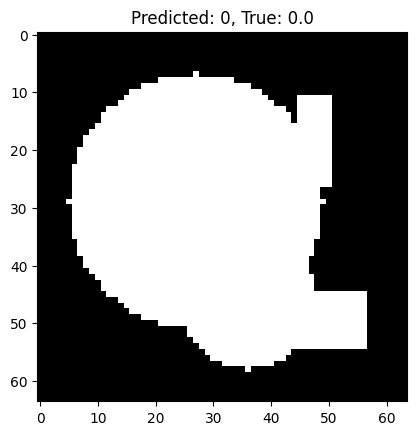

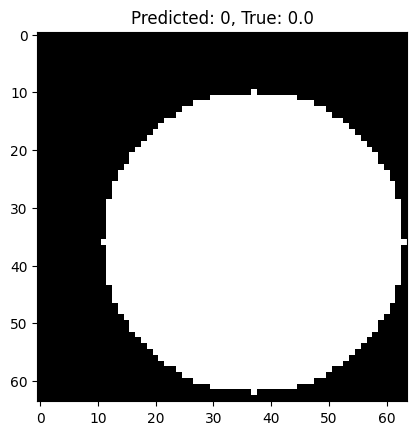

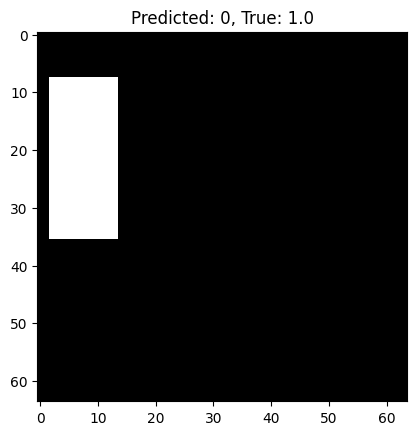

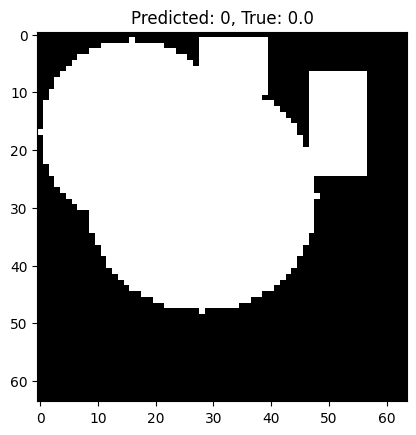

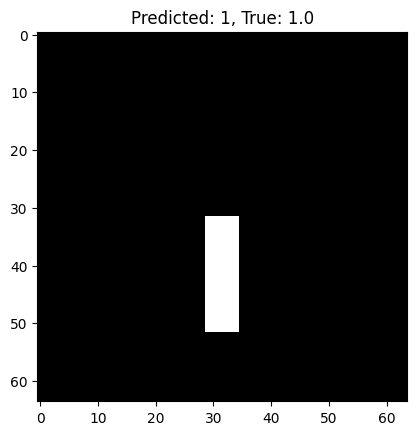

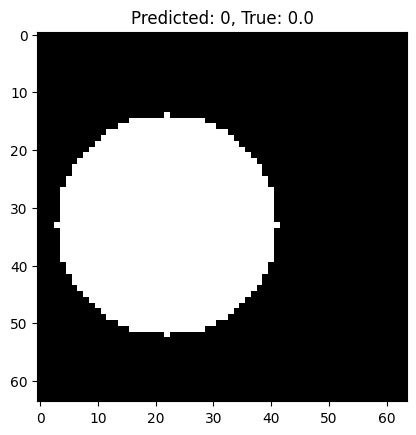

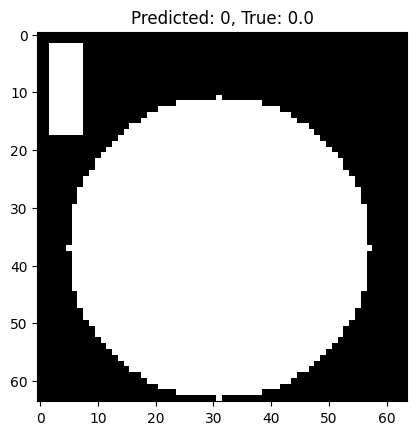

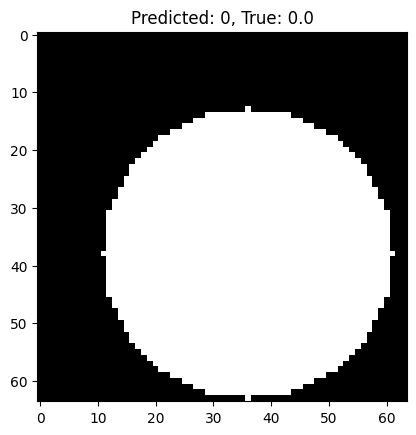

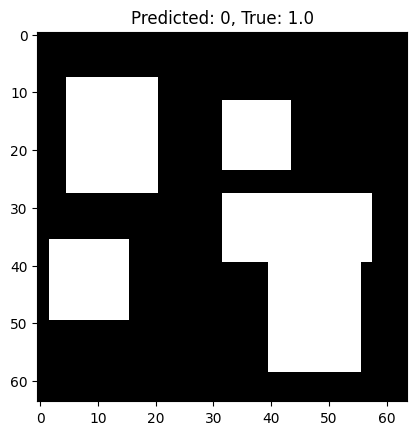

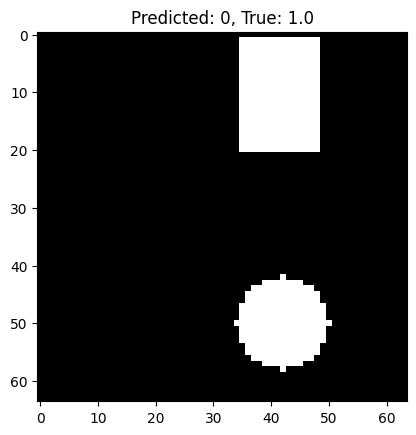

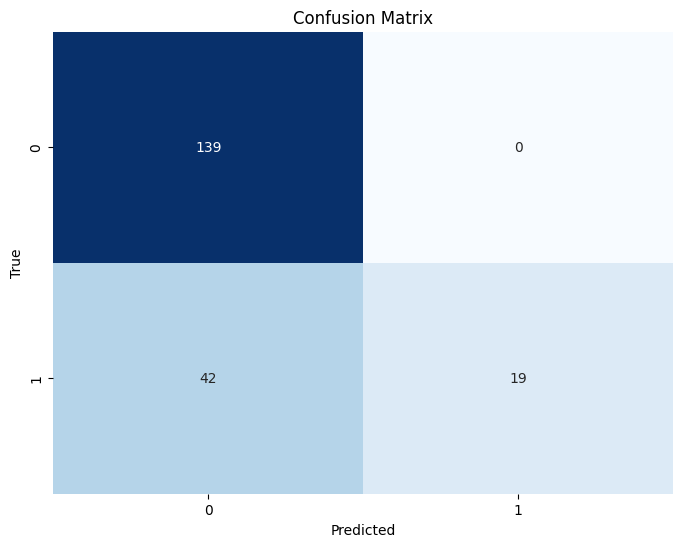

In [28]:
# -------------------------
# Inference and Evaluation
# -------------------------
test_dataset = MultiShapeDataset(num_samples=200, max_objects=5)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=num_workers)


predictions, true_labels = perform_inference(finetune_model, test_loader)
accuracy = np.mean(predictions == true_labels)
print(f"Test Accuracy: {accuracy}")

# Visualize some predictions
num_images_to_show = 10
for i in range(min(num_images_to_show, len(test_dataset))):
    image, label = test_dataset[i]
    predicted_label = predictions[i]
    plt.imshow(image.squeeze(), cmap='gray')
    plt.title(f"Predicted: {predicted_label[0]}, True: {label[0][0]}")
    plt.show()

# Plot confusion matrix
cm = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Self-supervised learning: NTXentLoss

In [29]:
# -------------------------
# NT-Xent Loss for Contrastive Learning
# -------------------------
class NTXentLoss(nn.Module):
    def __init__(self, temperature=0.5):
        super().__init__()
        self.temperature = temperature

    def forward(self, z1, z2):
        N = z1.size(0)
        z = torch.cat([z1, z2], dim=0)  # 2N x d
        # Since projections are normalized, cosine similarity is the dot product
        sim = torch.matmul(z, z.T)  # [2N, 2N]
        sim = sim / self.temperature

        # Mask out self-similarities by setting the diagonal to a very low value
        mask = torch.eye(2*N, dtype=torch.bool, device=z.device)
        sim = sim.masked_fill(mask, -1e9)

        # For each sample i, the positive sample is at index i+N if i < N, else i-N.
        positives = torch.cat([torch.diag(sim, N), torch.diag(sim, -N)])

        # Compute denominator for each sample
        exp_sim = torch.exp(sim)
        denom = exp_sim.sum(dim=1)
        loss = -torch.log(torch.exp(positives) / denom)

        return loss.mean()

In [30]:
# -------------------------
# Self-Supervised Pretraining Loop
# -------------------------
nt_xent_loss=NTXentLoss()
def pretrain_simclr(model, train_loader, optimizer, device, num_epochs=20, temperature=0.5):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for view1, view2, _ in train_loader:
            view1 = view1.to(device)
            view2 = view2.to(device)
            optimizer.zero_grad()
            _, proj1 = model(view1)
            _, proj2 = model(view2)
            loss = nt_xent_loss(proj1, proj2)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f'Pretrain Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}')

In [31]:
# -------------------------
# Main Script: Pretraining then Fine-Tuning
# -------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_workers = os.cpu_count()

# Self-supervised pretraining dataset and loader
ssl_dataset = SelfSupervisedMultiShapeDataset(num_samples=250, max_objects=5, transform=augmentation)
ssl_loader = DataLoader(ssl_dataset, batch_size=32, shuffle=True, num_workers=num_workers)

# Initialize encoder, projection head and SimCLR model
encoder = Encoder(im_channels=1, feature_dim=128)
proj_head = ProjectionHead(in_dim=128, proj_dim=64)
simclr_model = SimCLRModel(encoder, proj_head).to(device)
optimizer_ssl = optim.Adam(simclr_model.parameters(), lr=0.001)

print("Starting self-supervised pretraining...")
pretrain_simclr(simclr_model, ssl_loader, optimizer_ssl, device, num_epochs=1)

Starting self-supervised pretraining...
Pretrain Epoch 1/1, Loss: 3.6345


In [32]:
# After pretraining, use the encoder in a supervised classification model.
# Freeze or fine-tune the encoder as desired. Here, we fine-tune.
finetune_model = FineTuneModel(encoder, num_classes=1).to(device)
criterion = nn.BCELoss()
optimizer_ft = optim.Adam(finetune_model.parameters(), lr=0.001)

# Use the original MultiShapeDataset (which returns a single view)
train_dataset = MultiShapeDataset(num_samples=250, max_objects=5)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=num_workers)

print("Starting supervised fine-tuning...")
finetune(finetune_model, train_loader, criterion, optimizer_ft, device, num_epochs=1)



Starting supervised fine-tuning...
Finetune Epoch 1/1, Loss: 0.5209


Test Accuracy: 0.83


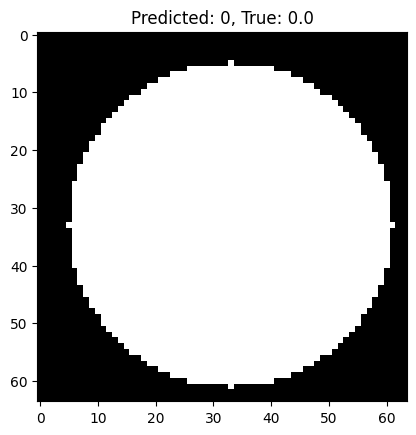

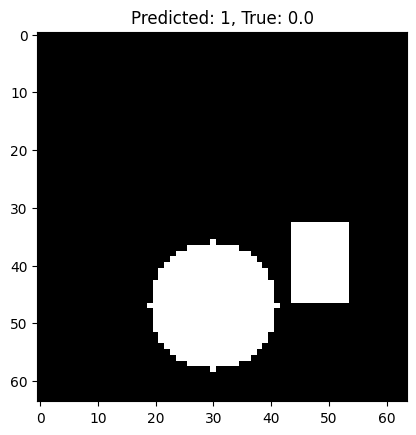

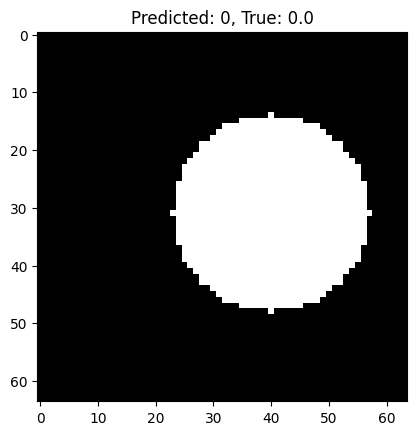

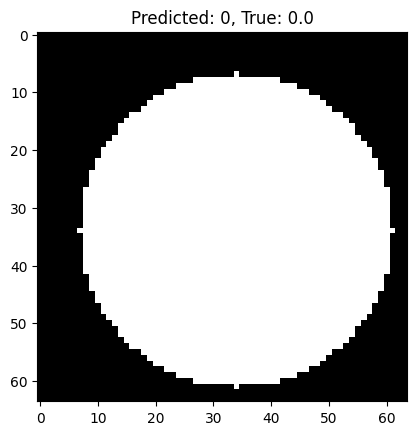

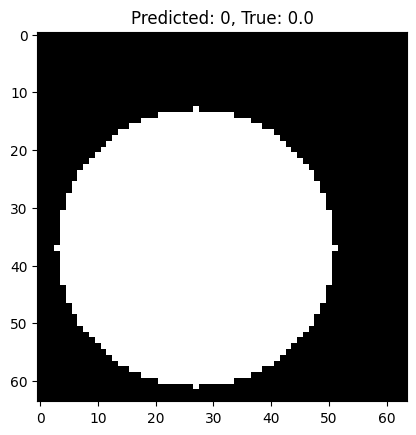

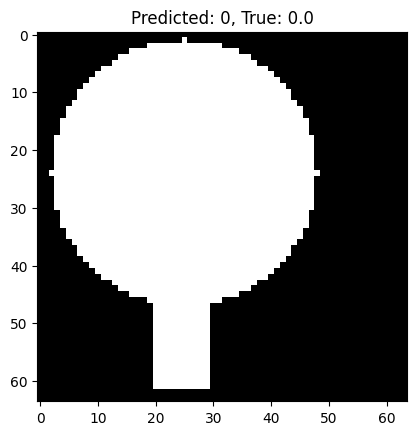

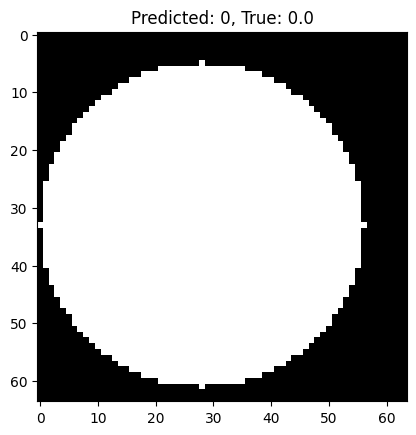

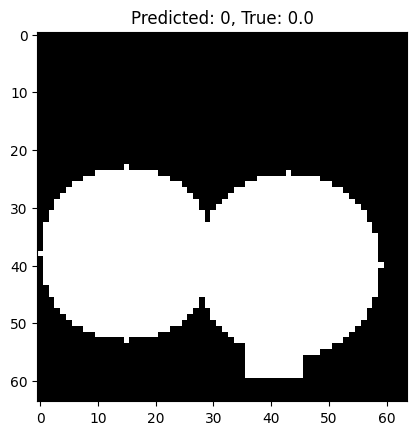

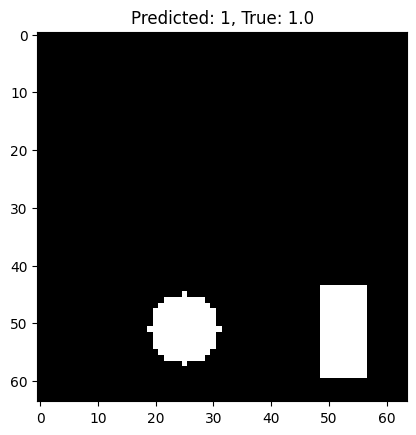

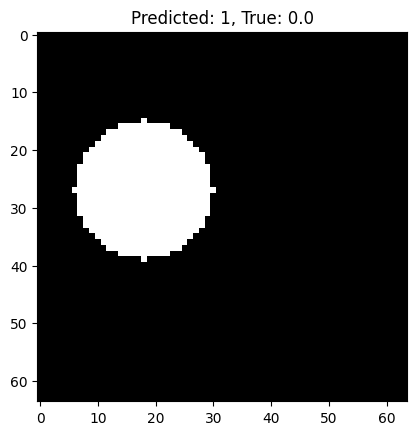

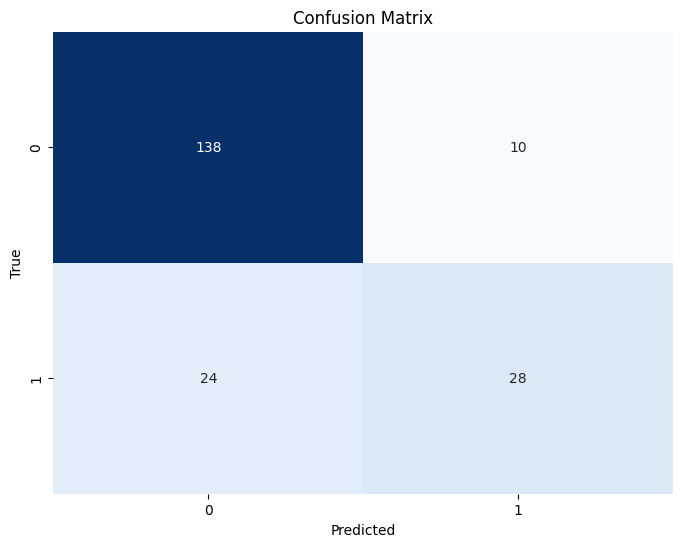

In [33]:
# -------------------------
# Inference and Evaluation
# -------------------------
test_dataset = MultiShapeDataset(num_samples=200, max_objects=5)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=num_workers)


predictions, true_labels = perform_inference(finetune_model, test_loader)
accuracy = np.mean(predictions == true_labels)
print(f"Test Accuracy: {accuracy}")

# Visualize some predictions
num_images_to_show = 10
for i in range(min(num_images_to_show, len(test_dataset))):
    image, label = test_dataset[i]
    predicted_label = predictions[i]
    plt.imshow(image.squeeze(), cmap='gray')
    plt.title(f"Predicted: {predicted_label[0]}, True: {label[0][0]}")
    plt.show()

# Plot confusion matrix
cm = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


# Supervised learning: Suppervised NT-Xent Loss

In [34]:
# -------------------------
# Suppervised NT-Xent Loss for Contrastive Learning
# -------------------------
class SupNTXentLoss(nn.Module):
    def __init__(self, temperature=0.5):
        super(SupNTXentLoss, self).__init__()
        self.temperature = temperature

    def forward(self, features, labels):
        """
        features: Tensor shape [batch_size, embedding_dim]
        labels:   Tensor shape [batch_size] (ชนิดข้อมูล int หรือ long)
        """
        # Modify this line to select the correct labels for comparison
        labels = labels[:, 0, 0]  # Select the first shape's label from each sample in the batch

        device = features.device
        batch_size = features.shape[0]

        # Normalize features สำหรับ cosine similarity
        features = F.normalize(features, p=2, dim=1)

        # คำนวณ similarity matrix ขนาด [batch_size, batch_size]
        similarity_matrix = torch.matmul(features, features.t()) / self.temperature

        # สร้าง mask สำหรับตัวอย่างเดียวกัน (ไม่เอา self-similarity)
        self_mask = torch.eye(batch_size, dtype=torch.bool, device=device)

        loss = 0.0
        count = 0

        for i in range(batch_size):
            # เลือก indices ของ positive samples: มี label เดียวกับ i แต่ไม่ใช่ i เอง
            pos_mask = (labels == labels[i]) & (~self_mask[i])
            if pos_mask.sum() == 0:
                continue  # หากไม่มี positive pair สำหรับ sample นี้
            # ค่าคล้ายคลึงของ sample i กับตัวอย่างอื่นๆ (ยกเว้นตัวเอง)
            logits = similarity_matrix[i][~self_mask[i]]
            # ค่าคล้ายคลึงของคู่ positive อยู่ใน pos_mask
            pos_logits = similarity_matrix[i][pos_mask]
            # คำนวณ denominator สำหรับ softmax
            denom = torch.sum(torch.exp(logits))
            # Loss สำหรับ sample i คือค่าเฉลี่ยของ -log(probability) สำหรับแต่ละ positive
            loss_i = - torch.log(torch.exp(pos_logits) / denom)
            loss += torch.mean(loss_i)
            count += 1

        return loss / count if count > 0 else loss

In [35]:
# -------------------------
# Supervised Pretraining Loop
# -------------------------
nt_xent_loss=SupNTXentLoss(temperature=0.5)
def pretrain_simclr(model, train_loader, optimizer, device, num_epochs=20):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for view1, view2, label in train_loader:
            view1 = view1.to(device)
            label = label.to(device)
            optimizer.zero_grad()
            _, proj1 = model(view1)
            loss = nt_xent_loss(proj1, label)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f'Pretrain Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}')

In [36]:
# -------------------------
# Main Script: Pretraining then Fine-Tuning
# -------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_workers = os.cpu_count()

# Self-supervised pretraining dataset and loader
ssl_dataset = SelfSupervisedMultiShapeDataset(num_samples=250, max_objects=5, transform=augmentation)
ssl_loader = DataLoader(ssl_dataset, batch_size=32, shuffle=True, num_workers=num_workers)

# Initialize encoder, projection head and SimCLR model
encoder = Encoder(im_channels=1, feature_dim=128)
proj_head = ProjectionHead(in_dim=128, proj_dim=64)
simclr_model = SimCLRModel(encoder, proj_head).to(device)
optimizer_ssl = optim.Adam(simclr_model.parameters(), lr=0.001)

print("Starting self-supervised pretraining...")
pretrain_simclr(simclr_model, ssl_loader, optimizer_ssl, device, num_epochs=1)

Starting self-supervised pretraining...
Pretrain Epoch 1/1, Loss: 3.3448


In [37]:
# After pretraining, use the encoder in a supervised classification model.
# Freeze or fine-tune the encoder as desired. Here, we fine-tune.
finetune_model = FineTuneModel(encoder, num_classes=1).to(device)
criterion = nn.BCELoss()
optimizer_ft = optim.Adam(finetune_model.parameters(), lr=0.001)

# Use the original MultiShapeDataset (which returns a single view)
train_dataset = MultiShapeDataset(num_samples=250, max_objects=5)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=num_workers)

print("Starting supervised fine-tuning...")
finetune(finetune_model, train_loader, criterion, optimizer_ft, device, num_epochs=1)

Starting supervised fine-tuning...
Finetune Epoch 1/1, Loss: 0.4719


Test Accuracy: 0.625


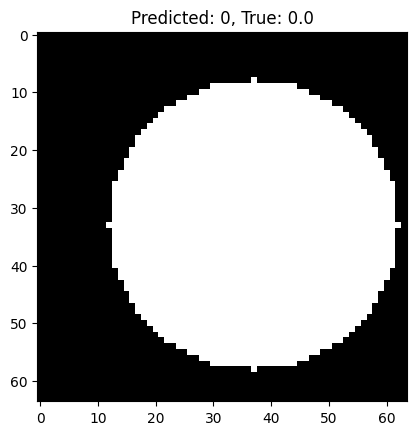

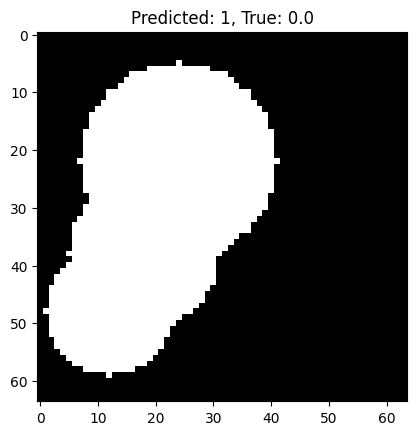

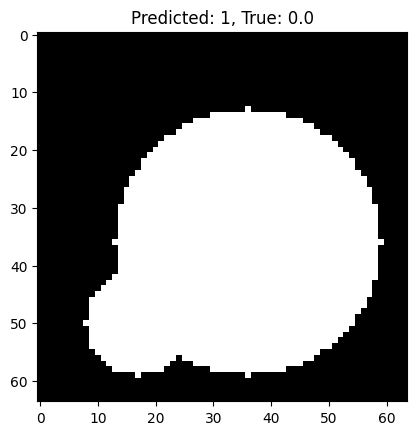

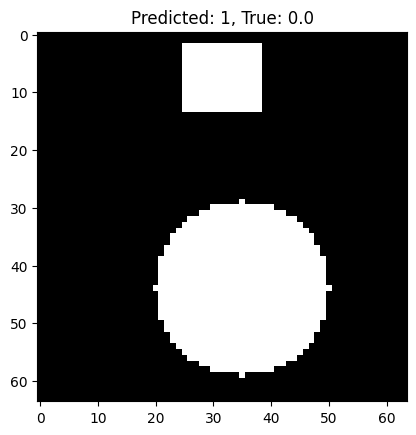

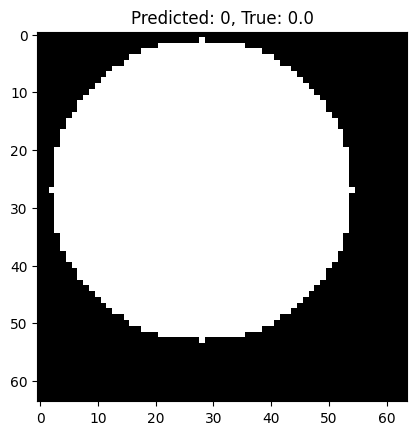

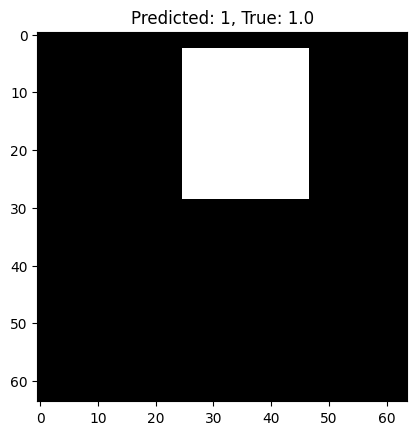

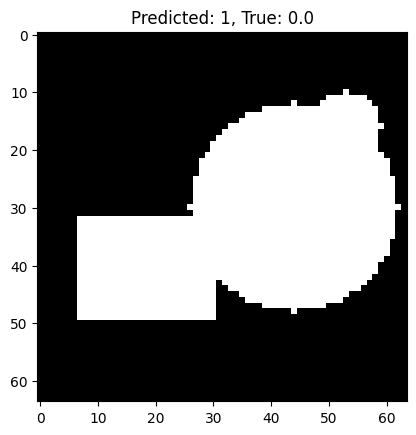

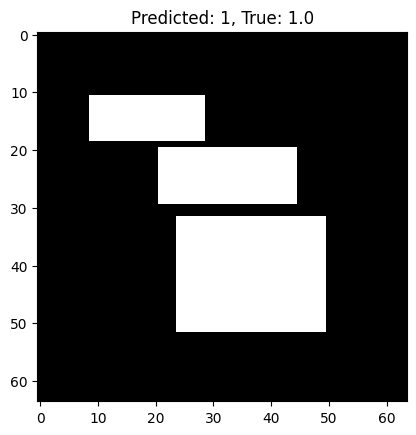

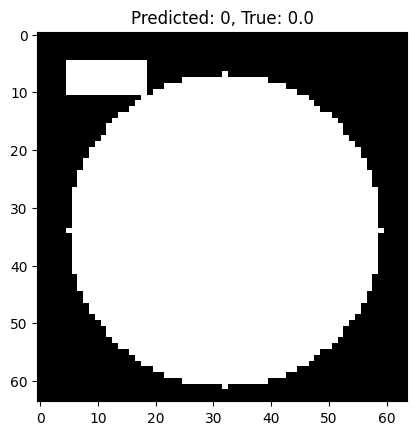

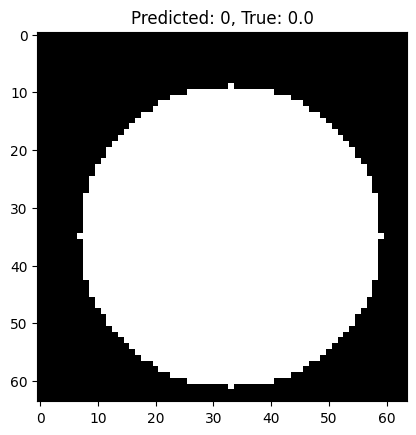

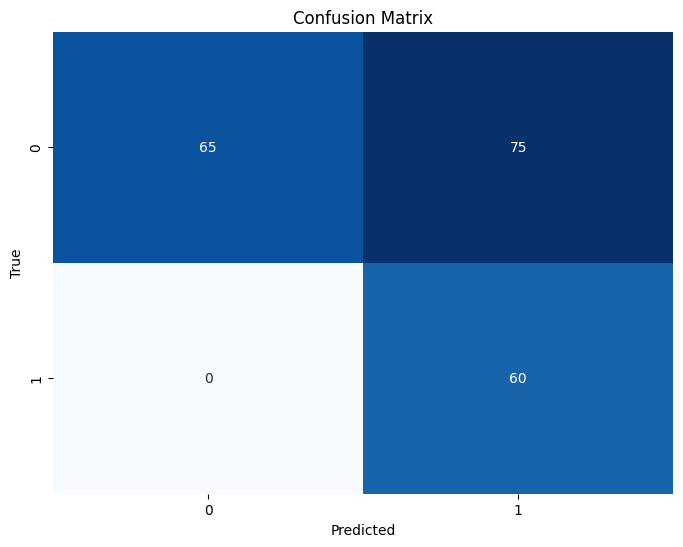

In [38]:
# -------------------------
# Inference and Evaluation
# -------------------------
test_dataset = MultiShapeDataset(num_samples=200, max_objects=5)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=num_workers)


predictions, true_labels = perform_inference(finetune_model, test_loader)
accuracy = np.mean(predictions == true_labels)
print(f"Test Accuracy: {accuracy}")

# Visualize some predictions
num_images_to_show = 10
for i in range(min(num_images_to_show, len(test_dataset))):
    image, label = test_dataset[i]
    predicted_label = predictions[i]
    plt.imshow(image.squeeze(), cmap='gray')
    plt.title(f"Predicted: {predicted_label[0]}, True: {label[0][0]}")
    plt.show()

# Plot confusion matrix
cm = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()
